# Solving 1D Poisson's Equations

We use ssde to solve the analytical solutions of a series of 1-dimensional poisson equations, where their analytical solutions are univariate expressions on the Nguyen benchmark.

## Data generation

In [3]:
import numpy as np
import sympy as sp
import tqdm
import os
def calculate_soure(solution):
    """
    Calculate the source term of the PDE

    Parameters
    ----------
    solution: sympy expression
        The solution of the PDE
    """
    real_params = dict()
    for symbol in sp.preorder_traversal(solution):
        if isinstance(symbol, sp.Symbol):
            exec('%s = sp.Symbol("%s")' % (symbol.name, symbol.name))
            if symbol.name not in real_params:
                real_params[symbol.name] = None
    real_params = sorted(list(real_params.keys()))
    solution_func = sp.lambdify(real_params, solution, modules='numpy')
    source = 0
    for i in real_params:
        source += sp.diff(solution, i, 2)
    if source != 0:
        source_func = sp.lambdify(real_params, source, modules='numpy')
    else:
        source_func = lambda *args: np.zeros_like(args[0])
    return solution_func, source_func, real_params

def poisson1d_data_generation(seed, test_index, data_path=None):
    """
    Generate the data for 1D Poisson equation

    Parameters
    ----------
    seed: int
        Random seed
    test_index: int
        The index of the test pde benchmark
    data_path: str
        The path to save the data
    """
    np.random.seed(seed)
    left_bc, right_bc = domain_dict[f'nguyen-{test_index}']
    # points number of pde constraints 
    n_samples = 20
    solution = sp.sympify(real_expression_dict[f'nguyen-{test_index}'])
    solution_func, source_func, real_params = calculate_soure(solution)
    n_vars = len(real_params)
    X = np.random.uniform(left_bc, right_bc, (n_samples, n_vars))
    X_bc = np.array([[left_bc],[right_bc]])
    X_combine = np.concatenate([X, X_bc], axis=0)
    y = source_func(*X_combine.T).reshape(-1, 1)
    y_bc = solution_func(*X_bc.T).reshape(-1, 1)
    assert X_combine.shape[0] == y.shape[0]
    assert X_bc.shape[0] == y_bc.shape[0]
    X_input = [X, X_bc]
    # Note: number of y includes internal points and boundary points.
    y_input = [y, y_bc]

    test_X = np.random.uniform(left_bc, right_bc, (10000, n_vars))
    test_y = solution_func(*test_X.T).reshape(-1, 1)
    if data_path is not None:
        if os.path.exists(data_path):
            os.remove(data_path)
        np.savez(data_path, X=X, X_bc=X_bc, y=y, y_bc=y_bc, test_X = test_X, test_y=test_y)
    return X_input, y_input, test_X, test_y


real_expression_dict = {
    'nguyen-1': "x1**3+x1**2+x1",
    'nguyen-2': "x1**4+x1**3+x1**2+x1",
    'nguyen-3': "x1**5+x1**4+x1**3+x1**2+x1",
    'nguyen-4': "x1**6+x1**5+x1**4+x1**3+x1**2+x1",
    'nguyen-5': "sin(x1**2) * cos(x1) - 1",
    'nguyen-6': "sin(x1) + sin(x1 + x1**2)",
    'nguyen-7': "log(x1+1)+log(x1**2+1)",
    'nguyen-8': "x1 ** 0.5",
}
domain_dict = {
    'nguyen-1': [-1, 1],
    'nguyen-2': [-1, 1],
    'nguyen-3': [-1, 1],
    'nguyen-4': [-1, 1],
    'nguyen-5': [-1, 1],
    'nguyen-6': [-1, 1],
    'nguyen-7': [0.5, 1.5],
    'nguyen-8': [0.5, 1.5],
}

In [4]:
# save the data
benchdata_path = "./benchdata/"
tqdm.tqdm.write("Generating data for Nguyen's benchmarks")
for i in range(1, 9):
    tqdm.tqdm.write(f"Generating data for nguyen-{i}")
    poisson1d_data_generation(0, i, f"{benchdata_path}nguyen-{i}.npz")
tqdm.tqdm.write("Data generation finished!")

Generating data for Nguyen's benchmarks
Generating data for nguyen-1
Generating data for nguyen-2
Generating data for nguyen-3
Generating data for nguyen-4
Generating data for nguyen-5
Generating data for nguyen-6
Generating data for nguyen-7
Generating data for nguyen-8
Data generation finished!


## SSDE solver

### Manner 1: Directly solving the equations 

In [2]:
from ssde import PDESymbolicSolver
from ssde.utils import jupyter_logging
import time

test_index = 1
Log_path = f'./single_log/poisson_nguyen_{test_index}.log'
if os.path.exists(Log_path):
    os.remove(Log_path)
@jupyter_logging(Log_path)
def cfs(test_index):
    model = PDESymbolicSolver("./configs/config_poisson1d.json")
    X_input, y_input, _, _ = poisson1d_data_generation(0, test_index)
    start_time = time.time()
    model.fit(X_input, y_input)
    print('Using time(s):', time.time()-start_time)
    print('Identified parametirc expression:')
    print(model.program_.sympy_expr)
    print('Identified traversal:')
    print(model.program_.traversal)
    return model

model = cfs(test_index)

/home/weishu/.conda/envs/ssde/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Manner 2: Running the code batchly

you can use the following command with the `.npz` file generated before to run the code batchly.

```bash
python3.6 -m ssde.ssde_run \
experiments/1dpoisson/configs/config_poisson1d.json \
--b=experiments/1dpoisson/benchdata/nguyen-1.npz \
--runs=20 \
--n_cores_task=20 \
--seed=500 \
> experiments/1dpoisson/exp_log/nguyen-1.log
```

In [80]:
import os
import pandas as pd
import numpy as np
from typing import Dict, Any

def parse_subdirectory_name(dirname: str) -> Dict[str, Any]:
    parts = dirname.split('_')
    result = {
        "is_ablation": False,
        "dataset_name": None
    }
    
    if "ablationexperiments" in parts:
        result["is_ablation"] = True
    try:
        benchdata_index = parts.index("benchdata")
        if benchdata_index + 1 < len(parts):
            dataset_part = parts[benchdata_index + 1]
            result["dataset_name"] = dataset_part.split('-')[0] + '-' + dataset_part.split('-')[1]
    except ValueError:
        pass
    
    return result

def extract_summary_data(root_log_dir: str = "../../log") -> Dict[str, Dict[str, Any]]:
    data_dict = {}
    root_dir = os.path.abspath(root_log_dir)
    
    for dirname in os.listdir(root_dir):
        dirpath = os.path.join(root_dir, dirname)
        if not os.path.isdir(dirpath):
            continue
        
        metadata = parse_subdirectory_name(dirname)
        if metadata["dataset_name"] is None:
            print(f"Skip catalog (cannot resolve dataset name): {dirpath}")
            continue
        
        summary_path = os.path.join(dirpath, "summary.csv")
        if not os.path.exists(summary_path):
            print(f"Skip directories (no summary.csv): {dirpath}")
            continue
        
        try:
            df = pd.read_csv(summary_path)
            if "t" not in df.columns or "n_samples" not in df.columns:
                print(f"Skip directory (missing columns): {dirpath}")
                continue
            
            data_dict[dirpath] = {
                **metadata,
                "t": df["t"].to_numpy(),
                "n_samples": df["n_samples"].to_numpy()
            }
            print(f"Extract successfully: {dirpath}")
        except Exception as e:
            print(f"Failed: {dirpath}, Error: {e}")
    
    return data_dict



data = extract_summary_data()
# sort the data according to the dataset name
data = dict(sorted(data.items(), key=lambda x: x[0]))
ablation_time, exp_time = [], []
ablation_samples, exp_samples = [], []
for dirpath, info in data.items():
    average_time = info['t'].mean()
    average_samples = info['n_samples'].mean()
    if info['is_ablation']:
        ablation_time.append(average_time)
        ablation_samples.append(average_samples)
    else:
        exp_time.append(average_time)
        exp_samples.append(average_samples)

    


Extract successfully: /home/weishu/ssde_release/SSDE/ssde/log/solver_ablationexperiments_1dpoisson_benchdata_nguyen-5_2025-03-28-220706
Extract successfully: /home/weishu/ssde_release/SSDE/ssde/log/solver_experiments_1dpoisson_benchdata_nguyen-5_2025-03-29-131633
Extract successfully: /home/weishu/ssde_release/SSDE/ssde/log/solver_experiments_1dpoisson_benchdata_nguyen-6_2025-03-29-133935
Extract successfully: /home/weishu/ssde_release/SSDE/ssde/log/solver_ablationexperiments_1dpoisson_benchdata_nguyen-6_2025-03-29-142045
Extract successfully: /home/weishu/ssde_release/SSDE/ssde/log/solver_ablationexperiments_1dpoisson_benchdata_nguyen-7_2025-03-29-143419
Extract successfully: /home/weishu/ssde_release/SSDE/ssde/log/solver_experiments_1dpoisson_benchdata_nguyen-7_2025-03-29-165806
Extract successfully: /home/weishu/ssde_release/SSDE/ssde/log/solver_experiments_1dpoisson_benchdata_nguyen-8_2025-03-29-173449
Extract successfully: /home/weishu/ssde_release/SSDE/ssde/log/solver_experiments

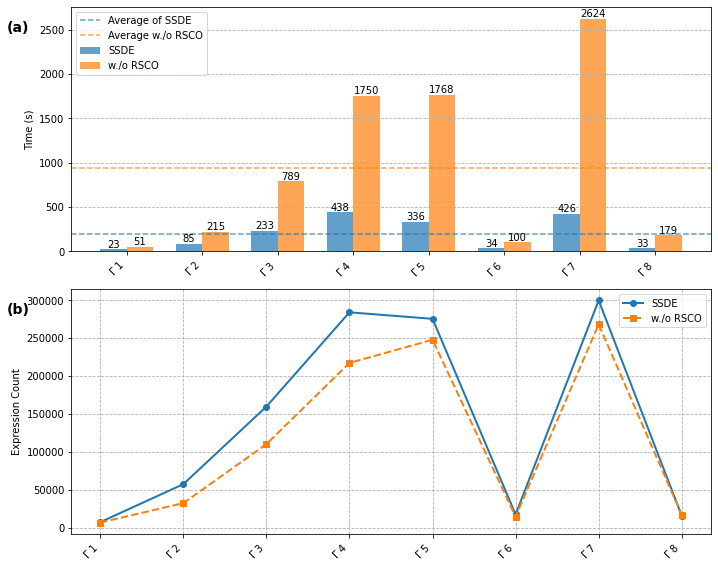

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
gamma_labels = [rf'$\Gamma$ {i+1}' for i in range(8)]
x = np.arange(len(gamma_labels))  # 横坐标位置 [0, 1, 2, 3, 4]
exp_time = [np.round(i,0) for i in exp_time]
ablation_time = [np.round(i,0) for i in ablation_time]

# ---------------------
# 时间对比柱状图
# ---------------------
ax1.axhline(y=np.mean(exp_time), color=bars_exp.patches[0].get_facecolor(), linestyle='--',label='Average of SSDE')
ax1.axhline(y=np.mean(ablation_time), color=bars_ablation.patches[0].get_facecolor(), linestyle='--',label='Average w./o RSCO')
width = 0.35
bars_exp = ax1.bar(x - width/2, exp_time, width, label='SSDE', color='#1f77b4', alpha=0.7)
bars_ablation = ax1.bar(x + width/2, ablation_time, width, label='w./o RSCO', color='#ff7f0e', alpha=0.7)

# 添加数值标签
for bar in bars_exp + bars_ablation:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.0f}', ha='center', va='bottom')

ax1.set_xticks(x)
ax1.set_xticklabels(gamma_labels, rotation=45, ha='right')
ax1.set_ylabel('Time (s)')
# ax1.set_title('Time Comparison')
ax1.text(-.1, .9, "(a)", transform=ax1.transAxes, fontdict={'size': '14', 'weight': 'bold', 'color': 'black'},zorder=4)
ax1.legend()
ax1.grid(axis='y', linestyle='--')

# ---------------------
# 样本对比曲线图
# ---------------------
ax2.text(-.1, .9, "(b)", transform=ax2.transAxes, fontdict={'size': '14', 'weight': 'bold', 'color': 'black'},zorder=4)
ax2.plot(x, exp_samples, label='SSDE', marker='o', color='#1f77b4', linewidth=2)
ax2.plot(x, ablation_samples, label='w./o RSCO', marker='s', color='#ff7f0e', linestyle='--', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(gamma_labels, rotation=45, ha='right')
ax2.set_ylabel('Expression Count')
# ax2.set_title('Number of Explored Expressions Comparison')
ax2.legend()
ax2.grid(True, linestyle='--')

# 调整布局
plt.tight_layout()
plt.savefig(r'ablation.pdf',
            dpi=900,bbox_inches='tight')
plt.show()